# Deep Sea Coral Data Analaysis

This notebook contains an analysis on the [NOAA Deep Sea Coral Dataset](https://deepseacoraldata.noaa.gov/). I found this dataset and wanted to learn what I could from it.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

## Data Preprocessing

In [2]:
coral_data = pd.read_csv('deep_sea_corals_data.csv')

/Users/kyle/projects/earthscience/notebooks/env/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (3,7,11,15,16,17,19,20,21,22,23,25,26,27,28,29,30,31,32,33,35,36,37) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Getting rid of the 0th row in the table as it only has additional metadata on the columns

In [3]:
coral_data = coral_data.drop(axis=0, index=0)

#### Overview of coral data
There are 40 different columns in this dataset. What kind of information can we learn about it?

In [4]:
coral_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 762132 entries, 1 to 762132
Data columns (total 40 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   ShallowFlag             762132 non-null  float64
 1   DatasetID               762132 non-null  object 
 2   CatalogNumber           762132 non-null  float64
 3   SampleID                618498 non-null  object 
 4   Repository              755149 non-null  object 
 5   ScientificName          762132 non-null  object 
 6   VernacularNameCategory  762132 non-null  object 
 7   VernacularName          272594 non-null  object 
 8   TaxonRank               762132 non-null  object 
 9   Family                  537880 non-null  object 
 10  Genus                   473151 non-null  object 
 11  Species                 217021 non-null  object 
 12  Ocean                   762132 non-null  object 
 13  Country                 739684 non-null  object 
 14  Locality            

The `ObservationDate` column of the dataset contains strings, in the format `'YYYY', 'YYYY-MM',` or `'YYYY-MM-DD'`.
This function normalizes this data.

In [5]:
from datetime import datetime
import math
def clean_date(date):
    """ Used to clean the observation date of the coral """
    if isinstance(date, float) and math.isnan(date): return date  # skip nan values
    if date == '-999': return float('nan')

    split_date = date.split('-')
    if len(split_date) == 1:
        year = int(split_date[0])
        month = 1
        day = 1
    elif len(split_date) == 2:
        year = int(split_date[0])
        month = int(split_date[1])
        day = 1
    else:
        year = int(split_date[0])
        month = int(split_date[1])
        day = int(split_date[2])

    return datetime(year=year, month=month, day=day)

coral_data['ObservationDate'] = coral_data['ObservationDate'].map(lambda x: clean_date((x)))

### Observations over the years

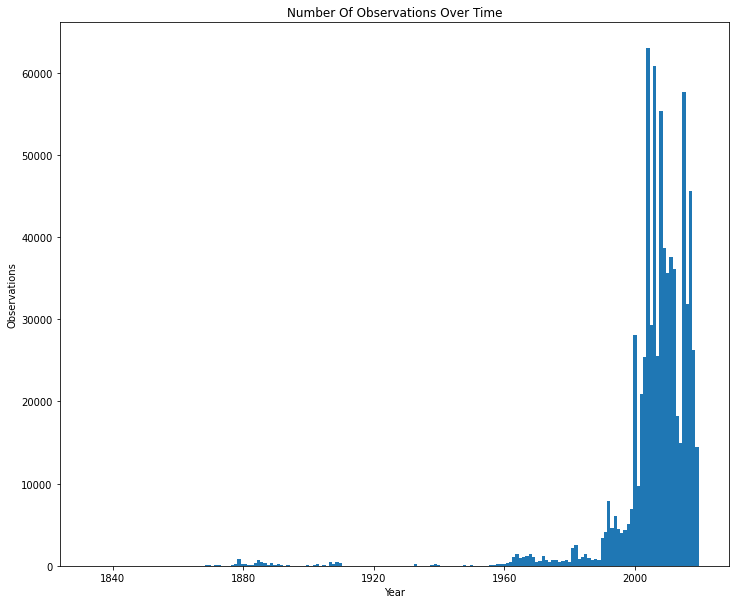

In [6]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(1,1,1)
ax.set_title('Number Of Observations Over Time')
ax.set_ylabel('Observations')
ax.set_xlabel('Year')
n_years = coral_data['ObservationDate'].max().year - coral_data['ObservationDate'].min().year
_ = ax.hist(
    coral_data['ObservationDate'],
    bins=n_years
)

In [7]:
def clean_geopoints(point):
    """ Clean lat/lon points """
    try:
        return float(point)
    except Exception:
        return float('nan')
coral_data['longitude'] = coral_data['longitude'].map(lambda x: clean_geopoints(x))
coral_data['latitude'] = coral_data['latitude'].map(lambda x: clean_geopoints(x))

In [8]:
def to_float(val):
    """ Convert values to float if possible """
    val = float(val)
    if val == -999.0:
        return float('nan')
    return val
coral_data['Temperature'] = coral_data['Temperature'].map(lambda x: to_float(x))
coral_data['Oxygen'] = coral_data['Oxygen'].map(lambda x: to_float(x))
coral_data['DepthInMeters'] = coral_data['DepthInMeters'].map(lambda x: to_float(x))

## Where are the datapoints?
We have data from all over the world. Lets see exactly where they are...

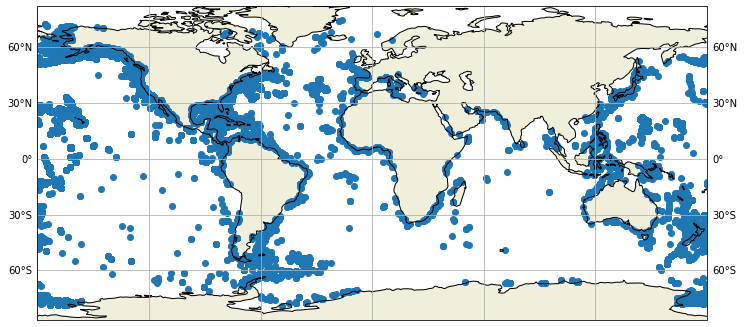

In [9]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.LAND)
ax.gridlines(draw_labels=True)
ax.scatter(
    x=coral_data['longitude'],
    y=coral_data['latitude']
)

### Temperature Changes over Time
Let's take a look at how temperature readings have changed over time. A normal scatter plot
will do nicely.

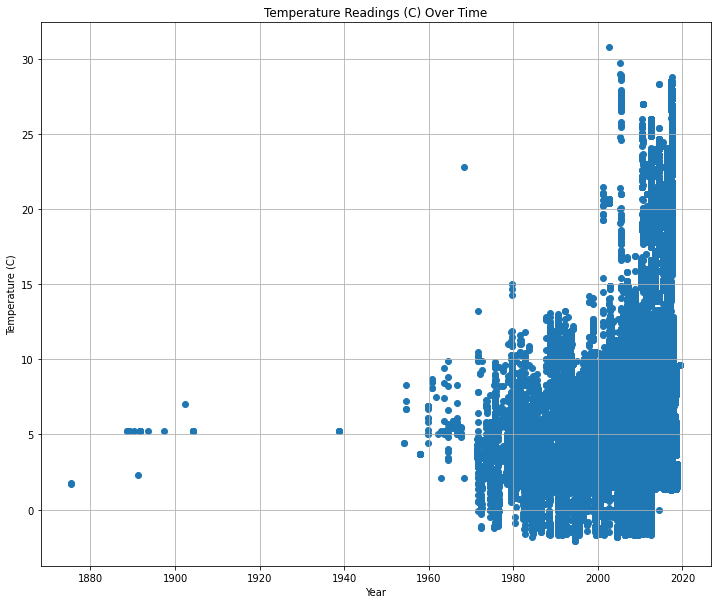

In [10]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(1,1,1)
ax.set_title('Temperature Readings (C) Over Time')
ax.set_ylabel('Temperature (C)')
ax.set_xlabel('Year')
ax.grid()
ax.scatter(
    x=coral_data['ObservationDate'],
    y=coral_data['Temperature'],
)

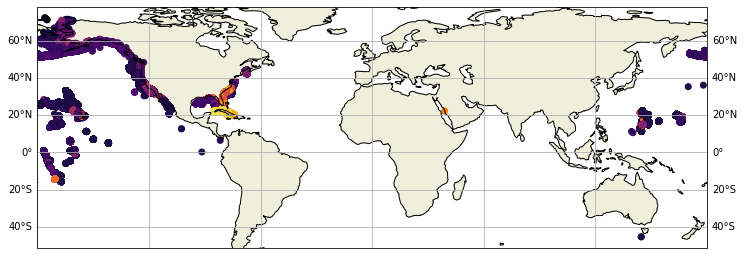

In [11]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.LAND)
ax.gridlines(draw_labels=True)
ax.scatter(
    x=coral_data['longitude'],
    y=coral_data['latitude'],
    c=coral_data['Temperature'], cmap='inferno',
)

Looks like most points are focused in the pacific ocean. Let's centralize there

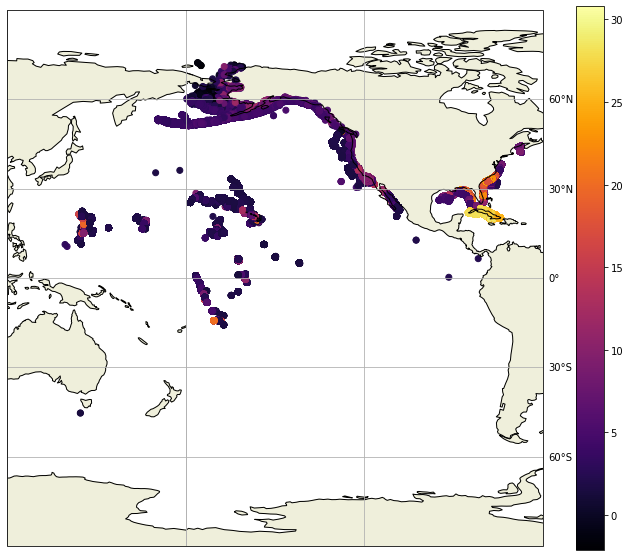

In [12]:
proj = ccrs.PlateCarree(central_longitude=-180)

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(1,1,1, projection=proj)
ax.set_extent([120, -60, -30, 80])
ax.coastlines()
ax.add_feature(cfeature.LAND)
ax.gridlines(draw_labels=True)
scat = ax.scatter(
    x=coral_data['longitude'].map(lambda lon: (proj.transform_point(lon, 0, ccrs.PlateCarree()))[0]),
    y=coral_data['latitude'].map(lambda lat: (proj.transform_point(0, lat, ccrs.PlateCarree()))[1]),
    c=coral_data['Temperature'], cmap='inferno',
)

fig.colorbar(scat)

So it looks like the Atlantic Ocean temperature readings are higher than most of the
Pacific Ocean readings. I will separate the two ocean datasets and look how temperature
has changed over time. It could be possible that the Atlantic Ocean temperature
readings were recorded more recently than the Pacific Ocean, leading to what looks
like the temperatures are increasing, where in reality it could just be due to
the location of the readings.

In [13]:
atl_coral = coral_data[coral_data['Ocean'].isin(['North Atlantic', 'South Atlantic'])]
pac_coral = coral_data[coral_data['Ocean'].isin(['North Pacific', 'South Pacific'])]

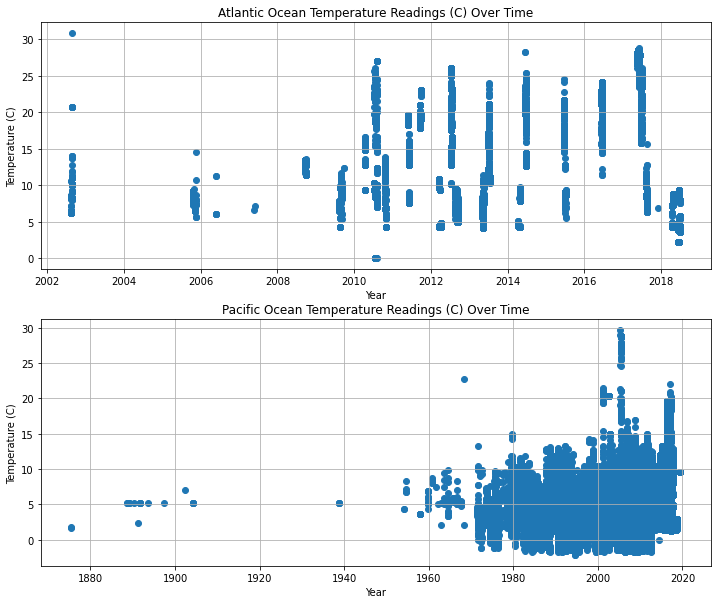

In [14]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(2,1,1)
ax.set_title('Atlantic Ocean Temperature Readings (C) Over Time')
ax.set_ylabel('Temperature (C)')
ax.set_xlabel('Year')
ax.grid()
ax.scatter(
    x=atl_coral['ObservationDate'],
    y=atl_coral['Temperature'],
)
ax2 = fig.add_subplot(2,1,2)
ax2.set_title('Pacific Ocean Temperature Readings (C) Over Time')
ax2.set_ylabel('Temperature (C)')
ax2.set_xlabel('Year')
ax2.grid()
ax2.scatter(
    x=pac_coral['ObservationDate'],
    y=pac_coral['Temperature'],
)

So it looks like the higher overall temperatures are due to the Atlantic Ocean
readings. It doesn't seem that there is a general upwards trend in the individual
oceans.

### Oxygen Content
Is there any interesting information we can find out via the oxygen content?
Let's find out.

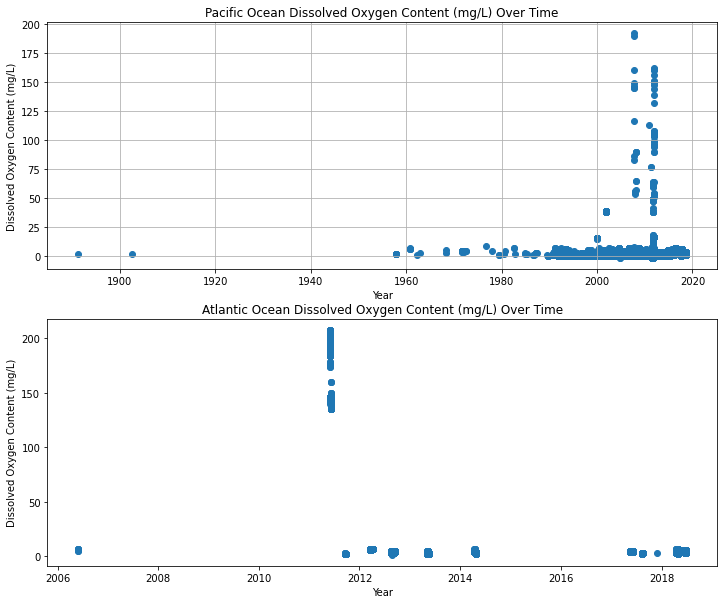

In [15]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(2,1,1)
ax.grid(linestyle='-')
ax.set_title('Pacific Ocean Dissolved Oxygen Content (mg/L) Over Time')
ax.set_xlabel('Year')
ax.set_ylabel('Dissolved Oxygen Content (mg/L)')
ax.scatter(
    x=pac_coral['ObservationDate'],
    y=pac_coral['Oxygen']
)
ax2 = fig.add_subplot(2,1,2)
ax2.set_title('Atlantic Ocean Dissolved Oxygen Content (mg/L) Over Time')
ax2.set_xlabel('Year')
ax2.set_ylabel('Dissolved Oxygen Content (mg/L)')
ax2.scatter(
    x=atl_coral['ObservationDate'],
    y=atl_coral['Oxygen']
)

Hmm, not sure what this means. I will have to think about a different way I can look at this data, to learn anything from it.

In [16]:
coral_data.groupby('Species').agg({'Species': 'count', 'DepthInMeters': 'mean'}).rename(columns={'Species': 'count'}).sort_values(by='count', ascending=False)

,count,DepthInMeters
Species,,
ritteri,25216,896.645463
pacifica,13479,625.775428
pertusa,12596,493.537790
occa,9630,1275.515680
lindahlii,6421,843.663292
...,...,...
halmaheirense,1,1089.000000
hamanni,1,121.000000
hamatum,1,210.000000


Where to from here? I will continue to explore this data as I come up with more ideas.